# Exercise 1 - 3D - 2D
aka pnp

In [2]:
import numpy as np
import cv2 as cv2
from numpy.linalg import inv, pinv
import matplotlib.pyplot as plt

Recall from the slides the steps from Algorithm 3:

![title](algorithm_3.png)

![title](PnP.png)

# Exercise 1a)
The steps 1)-2.1) has already been done, and is saved in corresponding files. The exercise is to implement step 2.2) by filling in the missing code below

In [10]:
def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCV to find the prev_points from the prev_img in the next_img
    Remember to remove points that could not be found from prev_points, next_points, and world_points
    hint: status == 1
    """
    params = dict(winSize=(21, 21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    #next_points, status, _ = ...
    next_points, status,_ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, None, **params)
    idx = np.array(status==1).ravel()
    next_points = next_points[idx]
    prev_points = prev_points[idx]
    world_points = world_points[idx]
    return world_points, prev_points, next_points

Hint: Exercise 4 in week 2

# Exercise 1b)
Continue the algorithm by implementing step 2.3)

In [11]:
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02], # camera matrix
              [0, 7.188560e+02, 1.852157e+02],
              [0, 0, 1]])

reference_img = np.load("img_" + str(0) + ".npy")

R = []
T = []
for t in range(1, 6):

    # the image at current time=t
    curImage = np.load("img_" + str(t) + ".npy")
    # the 3D landmarks in the world coordinates which have been computed in time=t-1
    landmark_3D = np.load("landmark_" + str(t-1) + ".npy")
    # the 2D coordinates of the 3D points in the previous frame at time=t-1
    reference_2D = np.load("reference_2D_" + str(t-1) + ".npy")
    
    # the 2D landmarks at the current time = t
    landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(reference_img, 
                                                                  curImage, 
                                                                  reference_2D,
                                                                  landmark_3D)
    
    """
    Using OpenCV, implement PnP using Ransac
    """
    #_, rvec, tvec, inliers = ...
    _, rvec, tvec, inliers = cv2.solvePnPRansac(landmark_3D,tracked_2Dpoints, K, None)

    """
    Transform the translation and rotation into the world frame
    """
    # what we get from the last step is the rotation and translation vectors to transform the world coordinates into camera coordinates
    rot,_ = cv2.Rodrigues(rvec)
    rot = pinv(rot)
    rvec,_ = cv2.Rodrigues(rot)
    tvec = -np.dot(rot, tvec)
    R.append(rvec)
    T.append(tvec)
    print(tvec[0], tvec[1], tvec[2], rvec[0], rvec[1], rvec[2])

    # update for next timestep
    reference_img = curImage

[-0.00110282] [-0.00067164] [-0.00078343] [7.40069205e-05] [7.35119058e-05] [-9.84544269e-05]
[-0.00363946] [-0.00875075] [0.67580842] [0.0021666] [-0.00325853] [0.00244333]
[-0.01096271] [-0.01635663] [1.3774094] [0.00364615] [-0.0075151] [0.00099691]
[-0.0315663] [-0.02560111] [2.0996797] [0.00509583] [-0.01121646] [0.00082978]
[-0.04971858] [-0.03532535] [2.8330071] [0.00561424] [-0.0161333] [-0.00041981]


Hint: The output should look similar to:

[-0.00110282] [-0.00067164] [-0.00078343] [-7.40069212e-05] [-7.35119065e-05] [9.84544279e-05]

[-0.00363946] [-0.00875075] [0.67580842] [-0.0021666] [0.00325853] [-0.00244333]

[-0.01096271] [-0.01635663] [1.3774094] [-0.00364615] [0.0075151] [-0.00099691]

[-0.0315663] [-0.02560111] [2.0996797] [-0.00509583] [0.01121646] [-0.00082978]

[-0.04971858] [-0.03532535] [2.8330071] [-0.00561424] [0.0161333] [0.00041981]

# Exercise 1c)
What approximate direction did the camera move in?

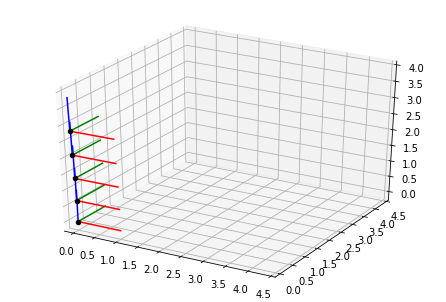

In [12]:
# Now we have the pose of the camera, we can reconstruct the movement
from mpl_toolkits.mplot3d import axes3d, Axes3D
fig = plt.figure()
ax = Axes3D(fig)
color = ['r', 'g', 'b']
for r, t in zip(R, T):
    r = cv2.Rodrigues(r)
    ax.scatter(t[0], t[1], t[2], color='k')
    for i in range(3):
        o = r[0][:,i]
        d = o+t.flatten()
        ax.plot([t[0], d[0]], [t[1], d[1]], [t[2], d[2]], color=color[i])
plt.xticks(np.arange(0, 5, step=0.5))
plt.yticks(np.arange(0, 5, step=0.5))
plt.show()